# Import and prepare Notebook Environement

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, confusion_matrix, accuracy_score
from imblearn.over_sampling import RandomOverSampler

In [2]:
sys.path.append(os.path.abspath("../../../src/"))
sys.path.append(os.path.abspath("../../../scripts/"))

In [4]:
from EmbVector import Vector
import sub_kaggle as sk

## **Models**
## Getting datas
**clean_art mode** : The "Sum" colum of datas is the sum of all word vector from the cleaned article having preprocessing. 

In [4]:
def get_model(is_balanced):
    if is_balanced:
        path = "../../../datas/skipgram_A3316_WS20_E20_B10000_R2000_CTrue.model"
    else:
        path = "../../../datas/skipgram_3284.model"
    return path

In [5]:
datas = Vector(data_file = "../../../datas/training_clean", 
        model_path = get_model(is_balanced = True), 
        is_training = True)
# type_sum values : gene_var, best_sim, clean_art, sim_gene_var
# top_number only use with best_sim or sim_gene_var, defautl = 50
datas.get_vector_datas(is_notebook = True, type_sum =  "clean_art")

________________________Getting datas vectors_______________________
____________________________________________________________________
Number of genes/variations not foud : 688
Number of article words not foud : 189
____________________________________________________________________
Getting vectors finished in 51.98251755000092 seconds


## Split the datas
Spliting the datas from the first model (without new articles) by 80% for training, and 20% fort test

In [7]:
X = datas.vectors[['Gene','Variation','Sum']]
Y = pd.get_dummies(datas.vectors["Class"]).values

#X = datas_unbalanced.vectors[['Gene','Variation','Sum']]
#Y = pd.get_dummies(datas_unbalanced.vectors["Class"]).values

In [8]:
print(X['Gene'].shape)
print(X['Variation'].shape)
print(X['Sum'].shape)

(3314,)
(3314,)
(3314,)


## Models : datas concatenated
First we need to split datas to reshape  and clean the shape

In [9]:
X_gene = X["Gene"]
X_var = X["Variation"]
X_sum = X["Sum"]

## **Building the model with Gene, Variation and Sum datas**

In [10]:
X_gene = X_gene.values.reshape(X_gene.shape[0], 1)
X_var = X_var.values.reshape(X_var.shape[0], 1)
X_sum = X_sum.values.reshape(X_sum.shape[0], 1)

In [11]:
def convert_to_np_gene(Object):
    np_list = []
    for obj in Object:
        cop = obj[0].copy()
        np_list.append(np.array(cop))
    return np.array(np_list)

def convert_to_np_var_sum(Object):
    np_list = []
    for obj in Object:
        for o in obj:
            cop = o[0].copy()
            np_list.append(np.array(cop))
    return np.array(np_list)

In [12]:
X_gene = convert_to_np_gene(X_gene)
X_var = convert_to_np_var_sum(X_var)
X_sum = convert_to_np_var_sum(X_sum)

In [13]:
print("X_gene : " + str(X_gene.shape))
print("X_var : " + str(X_var.shape))
print("X_sum : " + str(X_sum.shape))

print("Y : " + str(Y.shape))

X_gene : (3314, 100)
X_var : (3314, 100)
X_sum : (3314, 100)
Y : (3314, 9)


## Reform the X_train with cleaned shape

In [14]:
X_concat = np.concatenate((X_gene, X_var, X_sum), axis = 1) 

In [15]:
X_concat.shape

(3314, 300)

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X_concat, Y, test_size = 0.2, random_state = 42, stratify=Y)
print("X_train : " + str(X_train.shape))
print("Y_train : " + str(Y_train.shape))
print("X_test : " + str(X_test.shape))
print("Y_test : " + str(Y_test.shape))

X_train : (2651, 300)
Y_train : (2651, 9)
X_test : (663, 300)
Y_test : (663, 9)


## Over Sampling

In [17]:
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')

# fit and apply the transform
X_train, Y_train = oversample.fit_resample(X_train, Y_train)
X_train, Y_train = oversample.fit_resample(X_train, Y_train)

print(X_train.shape)
print(Y_train.shape)

(4128, 300)
(4128, 9)


In [18]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)
print(X_train.shape)
print(X_test.shape)

(4128, 300, 1)
(663, 300, 1)


## **Building CNN model with Gene, Variation and Sum datas**

## Model 1 : Simple

In [23]:
def create_model_simple():
    model = Sequential()
    model.add(layers.Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(layers.Conv1D(32, kernel_size=(3), activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(9, activation='softmax'))

    return model

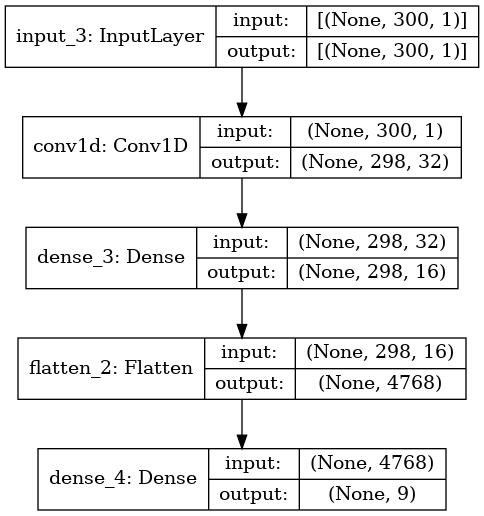

In [24]:
model_simple = create_model_simple()
model_simple.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
keras.utils.plot_model(model_simple, "CNN_W2V_ca.png", show_shapes= True)

## **Training**

## CNN Model 1 : Simple

In [35]:
history_simple = model_simple.fit(X_train, Y_train,
                     epochs=50,
                     verbose=False,
                     validation_split = 0.2,
                     batch_size= 32, 
                     callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
)

In [36]:
loss, accuracy = model_simple.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: %.3f %%"  % (accuracy * 100.0))

Training Accuracy: 83.454 %


In [37]:
loss, accuracy = model_simple.evaluate(X_test, Y_test, verbose=False)

print("Testing Accuracy:  %.3f %%"  % (accuracy * 100.0))

Testing Accuracy:  67.270 %


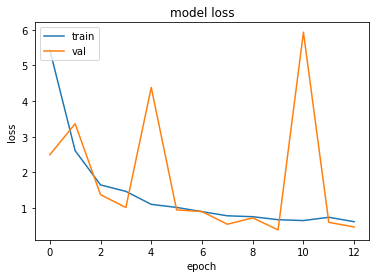

In [38]:
# summarize history for loss
plt.plot(history_simple.history['loss'])
plt.plot(history_simple.history['val_loss'])
plt.title("model loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

## **Saving models**

In [45]:
#model_simple.save("../../../results/Models/skipgram_over_sampling/skipgram_os_cnn_simple_Concat_ca.model")

INFO:tensorflow:Assets written to: ../../../results/Models/skipgram_over_sampling/skipgram_os_cnn_simple_Concat_ca.model/assets


__________________________________

# Clear the Session and delete model

In [47]:
keras.backend.clear_session()
del model_simple

__________________________________

__________________________________

# **Confusion matrix**

In [48]:
def plot_matrices(model, x_test, y_test):
  probas = model.predict(x_test)
  pred_indices = np.argmax(probas, axis=1)
  classes = np.array(range(1, 10))
  preds = classes[pred_indices]
  print('Log loss: {}'.format(log_loss(classes[np.argmax(y_test, axis=1)], probas)))
  print('Accuracy: {}'.format(accuracy_score(classes[np.argmax(y_test, axis=1)], preds))) 

  confusion  = confusion_matrix(classes[np.argmax(y_test, axis=1)], preds)
  precision =(confusion/confusion.sum(axis=0))
  recall =(((confusion.T)/(confusion.sum(axis=1))).T)
  f,(ax1,ax2,ax3, axcb) = plt.subplots(1,4, gridspec_kw={'width_ratios':[1,1,1,0.08]},figsize=(22,6)) 
  labels = [1,2,3,4,5,6,7,8,9]

  # Confusion matrix 
  g1 = sns.heatmap(confusion,cbar=False,ax=ax1,annot=True, cmap="Blues", fmt=".3f", xticklabels=labels, yticklabels=labels,)
  g1.set_ylabel('Original Class')
  g1.set_xlabel('Predicted Class')
  g1.set_title('Confusion') 

  # Precision matrix 
  g2 = sns.heatmap(precision,cmap="Blues",cbar=False,ax=ax2, annot=True,fmt=".3f", xticklabels=labels, yticklabels=labels)
  g2.set_ylabel('Original Class')
  g2.set_xlabel('Predicted Class')
  g2.set_yticks(labels)
  g2.set_title('Precision') 

  # Recall matrix 
  g3 = sns.heatmap(recall,cmap="Blues",ax=ax3, cbar_ax=axcb, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
  g3.set_ylabel('Original Class')
  g3.set_xlabel('Predicted Class')
  g3.set_title('Recall')
  g3.set_yticks(labels) 

  for ax in [g1,g2,g3]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, rotation=0)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0)
  
  plt.show()


In [49]:
#model_simple = keras.models.load_model("../../../results/Models/skipgram_over_sampling/skipgram_os_cnn_simple_Concat_ca.model")

Log loss: 1.1638031040646595
Accuracy: 0.6726998491704375


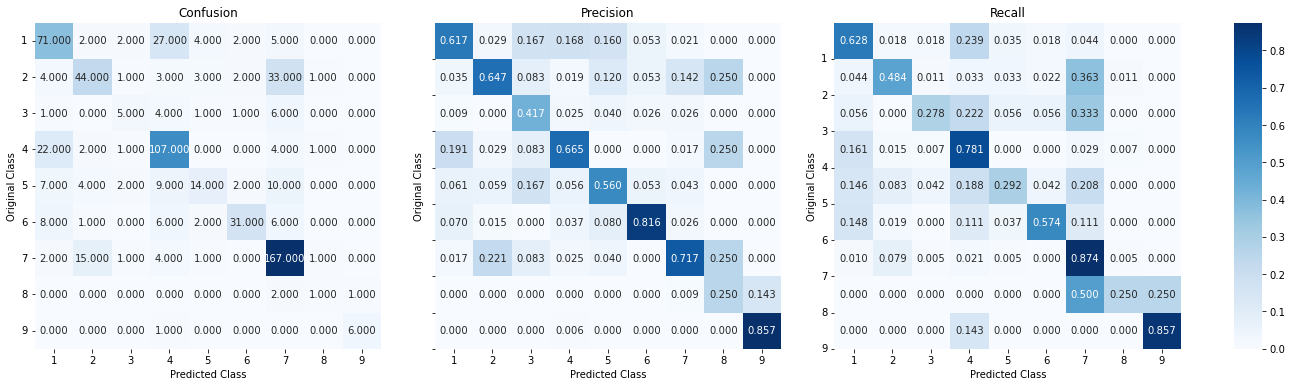

In [52]:
plot_matrices(model_simple, X_test, Y_test)

__________________________________

__________________________________

# Kaggle Submission

In [5]:
def get_model_sub():
    return "../../../datas/skipgram_A3316_WS20_E20_B10000_R2000_CTrue.model"

In [8]:
datas = Vector(data_file = "../../../datas/stage2_test_clean", 
        model_path = get_model_sub(), 
        is_training = False)
# type_sum values : gene_var, best_sim, clean_art, sim_gene_var
# top_number only use with best_sim or sim_gene_var, defautl = 50
datas.get_vector_datas(is_notebook = True, type_sum =  "clean_art")

________________________Getting datas vectors_______________________
____________________________________________________________________
Number of genes/variations not foud : 682
Number of article words not foud : 15546
____________________________________________________________________
Getting vectors finished in 13.214093315000355 seconds


## Split the datas
Spliting the datas from the first model (without new articles) by 80% for training, and 20% fort test

In [10]:
X = datas.vectors[['Gene','Variation','Sum']]

In [11]:
print(X['Gene'].shape)
print(X['Variation'].shape)
print(X['Sum'].shape)

(591,)
(591,)
(591,)


## Models : datas concatenated
First we need to split datas to reshape  and clean the shape

In [12]:
X_gene = X["Gene"]
X_var = X["Variation"]
X_sum = X["Sum"]

## **Building the model with Gene, Variation and Sum datas**

In [13]:
X_gene = X_gene.values.reshape(X_gene.shape[0], 1)
X_var = X_var.values.reshape(X_var.shape[0], 1)
X_sum = X_sum.values.reshape(X_sum.shape[0], 1)

In [14]:
def convert_to_np_gene(Object):
    np_list = []
    for obj in Object:
        cop = obj[0].copy()
        np_list.append(np.array(cop))
    return np.array(np_list)

def convert_to_np_var_sum(Object):
    np_list = []
    for obj in Object:
        for o in obj:
            cop = o[0].copy()
            np_list.append(np.array(cop))
    return np.array(np_list)

In [15]:
X_gene = convert_to_np_gene(X_gene)
X_var = convert_to_np_var_sum(X_var)
X_sum = convert_to_np_var_sum(X_sum)

In [17]:
print("X_gene : " + str(X_gene.shape))
print("X_var : " + str(X_var.shape))
print("X_sum : " + str(X_sum.shape))

X_gene : (591, 100)
X_var : (591, 100)
X_sum : (591, 100)


## Reform the X_train with cleaned shape

In [18]:
X_concat = np.concatenate((X_gene, X_var, X_sum), axis = 1) 

In [19]:
X_concat.shape

(591, 300)

In [21]:
X_concat = X_concat.reshape(X_concat.shape[0],X_concat.shape[1], 1)
print(X_concat.shape)

(591, 300, 1)


In [34]:
model_trained = keras.models.load_model("../../../results/Models/skipgram_over_sampling/skipgram_os_cnn_simple_Concat_ca.model")

In [35]:
sub_datas = sk.kaggle_dtf(model_trained, X_concat)

In [44]:
for row in sub_datas.iterrows():
    if row[1]['class8']==1:
        print(row)

(216, ID        217
class1      0
class2      0
class3      0
class4      0
class5      0
class6      0
class7      0
class8      0
class9      1
Name: 216, dtype: int64)
(305, ID        306
class1      0
class2      0
class3      0
class4      0
class5      0
class6      0
class7      0
class8      0
class9      1
Name: 305, dtype: int64)
(321, ID        322
class1      0
class2      0
class3      0
class4      0
class5      0
class6      0
class7      0
class8      0
class9      1
Name: 321, dtype: int64)
(331, ID        332
class1      0
class2      0
class3      0
class4      0
class5      0
class6      0
class7      0
class8      0
class9      1
Name: 331, dtype: int64)
(421, ID        422
class1      0
class2      0
class3      0
class4      0
class5      0
class6      0
class7      0
class8      0
class9      1
Name: 421, dtype: int64)
(542, ID        543
class1      0
class2      0
class3      0
class4      0
class5      0
class6      0
class7      0
class8      0
class9      1

In [ ]:
sub_datas.to_csv("sci_bert_kaggle.csv",index = False)